# Introduction

How much does what is included in the annotation set matter?

In [1]:
import seaborn
import scipy
import anndata
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot, cm
import sys
import pysam
from collections import Counter
from IPython import display

import upsetplot

In [2]:
pandas.options.display.max_rows = 300

In [3]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/lung/ENCSR966DDY_16f_nuc'

In [4]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [5]:
v29_genome_dir = Path("~/proj/genome/").expanduser()
v29_store = pandas.HDFStore(v29_genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
v29_gtf = v29_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v29_store.close()

v29_gene_base_to_id = {}
v29_gene_id_to_name = {}
v29_gene_id_to_type = {}
for i, row in v29_gtf.iterrows():
    v29_gene_base_to_id[row.gene_id.split('.')[0]] = row.gene_id
    v29_gene_id_to_name[row.gene_id] = row.gene_name
    v29_gene_id_to_type[row.gene_id] = row.gene_type

def calculate_v29_gene_base(gene_id):
    gene_base = gene_id.split('.')[0]
    if gene_id.endswith("_PAR_Y"):
        gene_base += "_PAR_Y"
    return gene_base
v29_gtf['gene_base'] = v29_gtf['gene_id'].apply(calculate_v29_gene_base)

In [6]:
v32m_genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
v32m_store = pandas.HDFStore(v32m_genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
v32m_gtf = v32m_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v32m_store.close()

v32m_gtf.columns = ['gene_base', 'gene_name', 'gene_type']
v32m_gtf['gene_id'] = v32m_gtf['gene_base'].apply(lambda x: v29_gene_base_to_id.get(x, x))

v32m_gene_id_to_name = {}
v32m_gene_id_to_type = {}
for i, row in v32m_gtf.iterrows():
    v32m_gene_id_to_name[row.gene_id] = row.gene_name
    v32m_gene_id_to_type[row.gene_id] = row.gene_type

In [7]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]

    analysis_dir = Path(analysis_dir)
    feature_name = "features.tsv"
    
    solo_dir = analysis_dir / "Solo.out" / quantification / mode
    solo = scanpy.read_mtx(solo_dir / "matrix.mtx").T
    solo_vars = pandas.read_csv(
        solo_dir / feature_name, header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



# Load Datasets

In [8]:
algorithm_roots = {
    'tenx solo uniq': Path("starsolo_2.7.9a_2021-06-25_encode-forward+cr"),
    'encode full solo uniq': Path("fullsolo_2.7.9a_2021-06-25"),
    #'encode full solo rescue': Path("fullsolo_rescue_2.7.9a_2021-06-25"),
    #'encode full solo em': Path("fullsolo_em_2.7.9a_2021-06-25"),
    'encode minimal solo uniq': Path("minimalsolo_2.7.9a_2021-06-25"),
    #'encode minimal solo rescue': Path("minimalsolo_rescue_2.7.9a_2021-06-25"),
    #'encode minimal solo em': Path("minimalsolo_em_2.7.9a_2021-06-25"),
}

In [9]:
algorithm_filtered = {}
for algorithm in algorithm_roots:
    print("loading {}".format(algorithm))
    algorithm_filtered[algorithm] = scanpy_load_solo278a_mtx(algorithm_roots[algorithm], "GeneFull", "filtered")
    print(algorithm, algorithm_filtered[algorithm].shape, algorithm_filtered[algorithm].X.sum())

loading tenx solo uniq
tenx solo uniq (8472, 36601) 38258610.0
loading encode full solo uniq
encode full solo uniq (8333, 59526) 36305940.0
loading encode minimal solo uniq
encode minimal solo uniq (8396, 28249) 36186204.0


# Add (faked) version to 10x annotation

The 10x provided annotation GTF file, based on GENCODE V32, has the gene version number removed, to make later comparisons easier I added the gene version number from my V29 GTF on to the V32 gene base ids.

(Gene base = ENSG00000243485)

(Gene id with version = ENSG00000243485.5)

In [10]:
algorithm_filtered['tenx solo uniq'].var_names[:5]

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945'],
      dtype='object')

In [11]:
algorithm_filtered['tenx solo uniq'].var_names = v32m_gtf.set_index('gene_base').reindex(algorithm_filtered['tenx solo uniq'].var_names.to_list())['gene_id']

In [12]:
algorithm_filtered['tenx solo uniq'].var_names[:5]

Index(['ENSG00000243485.5', 'ENSG00000237613.2', 'ENSG00000186092.6',
       'ENSG00000238009.6', 'ENSG00000239945.1'],
      dtype='object', name='gene_id')

# Remove version from ENCODE annotations

In [13]:
#algorithm_filtered['encode minimal solo uniq'].var_names

In [14]:
#for algorithm in algorithm_filtered:
#    if algorithm != 'tenx solo uniq':
#        algorithm_filtered[algorithm].var_names = [x.split('.')[0] for x in algorithm_filtered[algorithm].var_names]


In [15]:
#algorithm_filtered['encode minimal solo uniq'].var_names

# Cell barcodes in common

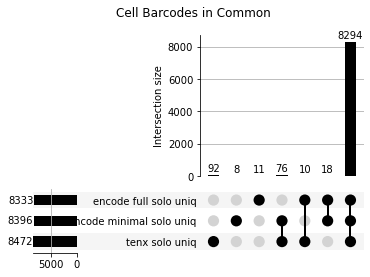

In [16]:
algorithm_cell_barcodes = {}
for algorithm in algorithm_filtered:
    algorithm_cell_barcodes[algorithm] = algorithm_filtered[algorithm].obs_names

common_cell_barcode_set = upsetplot.from_contents(algorithm_cell_barcodes)
f = pyplot.figure()
f.suptitle("Cell Barcodes in Common")
_ = upsetplot.plot(common_cell_barcode_set, fig=f, show_counts=True)


# Gene IDs in common

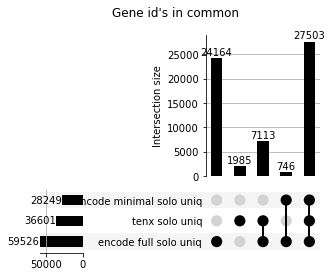

In [17]:
algorithm_gene_base_ids = {}
for algorithm in algorithm_filtered:
    algorithm_gene_base_ids[algorithm] = set(algorithm_filtered[algorithm].var_names)

common_gene_base_contents = upsetplot.from_contents(algorithm_gene_base_ids)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
f = pyplot.figure()
f.suptitle("Gene id's in common")
_ = upsetplot.plot(common_gene_base_contents, fig=f, show_counts=True)

# What are some of those genes in tenx & encode full 

In [18]:
not_in_encode_minimal = common_gene_base_contents.loc[True,True,False]['id'].values

changed_between_versions = []
for gene_base in not_in_encode_minimal:
    changed_between_versions.append({
        'gene_base': gene_base,
        'v29_type': v29_gene_id_to_type[gene_base],
        'v32_type': v32m_gene_id_to_type[gene_base],
    })
    
changed_between_versions = pandas.DataFrame(changed_between_versions)

<ipython-input-18-8e864a7ee1c3>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  not_in_encode_minimal = common_gene_base_contents.loc[True,True,False]['id'].values


In [19]:
changed_between_versions[changed_between_versions['v29_type'] != changed_between_versions['v32_type']]

,gene_base,v29_type,v32_type
0,ENSG00000229582.3,processed_transcript,lncRNA
1,ENSG00000275494.1,sense_intronic,lncRNA
2,ENSG00000254095.1,processed_transcript,lncRNA
3,ENSG00000266237.1,sense_intronic,lncRNA
4,ENSG00000235989.3,antisense,lncRNA
...,...,...,...
7108,ENSG00000255649.1,antisense,lncRNA
7109,ENSG00000261198.1,antisense,lncRNA
7110,ENSG00000223966.1,antisense,lncRNA
7111,ENSG00000228382.1,sense_intronic,lncRNA


In [20]:
changed_between_versions[changed_between_versions['v29_type'] != changed_between_versions['v32_type']]['v32_type'].unique()

array(['lncRNA', 'protein_coding'], dtype=object)

# Build list of cells and gene ids in common between all runs

In [21]:
common_cell_barcode_set = None
for algorithm in algorithm_filtered:
    if common_cell_barcode_set is None:
        common_cell_barcode_set = set(algorithm_filtered[algorithm].obs_names)
    else:
        common_cell_barcode_set = common_cell_barcode_set.intersection(algorithm_filtered[algorithm].obs_names)

print('common_cell_barcode_set', len(common_cell_barcode_set))
common_cell_barcodes = [x for x in algorithm_filtered['encode full solo uniq'].obs_names if x in common_cell_barcode_set]
print('common_cell_barcodes', len(common_cell_barcodes))


common_cell_barcode_set 8294
common_cell_barcodes 8294


In [22]:
common_gene_id_set = None
for algorithm in algorithm_filtered:
    #if algorithm == 'tenx solo uniq':
    #    continue
    if common_gene_id_set is None:
        common_gene_id_set = set(algorithm_filtered[algorithm].var_names)
    else:
        common_gene_id_set = common_gene_id_set.intersection(algorithm_filtered[algorithm].var_names)

print("common_gene_id_set", len(common_gene_id_set), len(set(common_gene_id_set)))
common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x in common_gene_id_set]
print("common_gene_ids", len(common_gene_ids), len(set(common_gene_ids)))

common_gene_id_set 27503 27503
common_gene_ids 27503 27503


In [23]:
#tenx_gene_base = set(algorithm_filtered['tenx solo uniq'].var_names)
#v29_common_gene_base = [x.split('.')[0] for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#v29_common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#print(len(v29_common_gene_base), v29_common_gene_base[:5])

In [24]:
algorithm_common = {}
for algorithm in algorithm_filtered:
    algorithm_common[algorithm] = algorithm_filtered[algorithm][common_cell_barcodes, common_gene_ids]
    print(algorithm, algorithm_common[algorithm].shape, algorithm_common[algorithm].X.sum())

tenx solo uniq (8294, 27503) 36903524.0
encode full solo uniq (8294, 27503) 34728470.0
encode minimal solo uniq (8294, 27503) 35971204.0


# Compute correlations of cells in common between all methods

In [25]:
def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.to_df().T
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.to_df().T

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


def compute_correlations(table):
    programs = list(table.keys())
    correlations = {}
    dense = {}
    for name_x in programs:
        dense[name_x] = table[name_x].to_df().T

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            print("Processing {} {}".format(name_x, name_y))
            cs_cors = compute_spearman_anndata(dense[name_x], dense[name_y])
            correlations.setdefault(name_x, {})[name_y] = cs_cors
    return correlations

algorithm_correlations = compute_correlations(algorithm_common)

Processing tenx solo uniq tenx solo uniq
Processing tenx solo uniq encode full solo uniq
Processing tenx solo uniq encode minimal solo uniq
Processing encode full solo uniq encode full solo uniq
Processing encode full solo uniq encode minimal solo uniq
Processing encode minimal solo uniq encode minimal solo uniq


In [26]:
def plot_cell_correlation_histogram(table, title=None, bins=50, programs=None):
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(10, 10))
    if title is not None:
        f.suptitle(title.format(metric=metric))
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = numpy.array(table[name_x][name_y])
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()
    

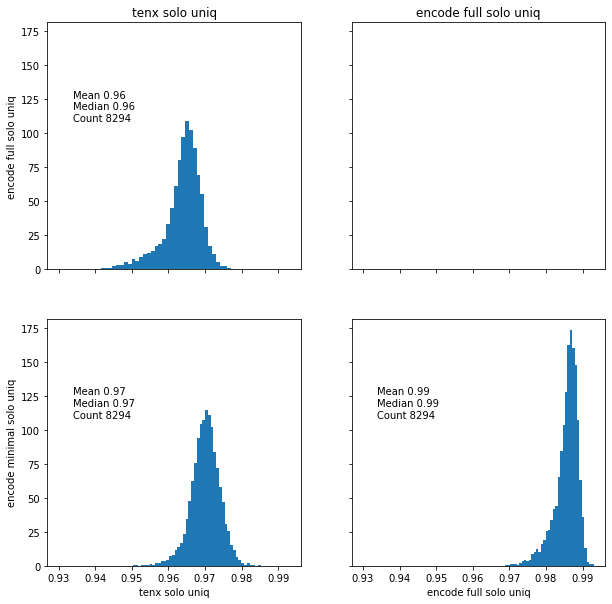

In [27]:
plot_cell_correlation_histogram(algorithm_correlations)

# Scatter plot of method genes in common over all cells

In [28]:
def plot_algorithm_sums(table, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    f = pyplot.figure(figsize=(10, 10))
    if title is not None:
        f.suptitle(title.format(metric=metric))
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            scatter.setdefault(name_x, {})[name_y] = ax.scatter(
                numpy.asarray(table[name_x].X.sum(axis=1).T)[0], 
                numpy.asarray(table[name_y].X.sum(axis=1).T)[0],
                s=0.5
            )
            ax.set_xscale('log')
            ax.set_yscale('log')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("per algorithm sum of genes over all cells")
    #f.tight_layout()
    

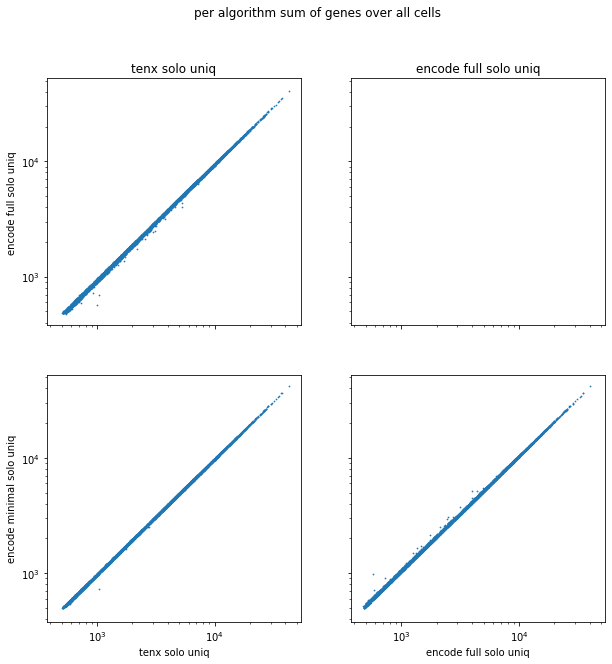

In [29]:
plot_algorithm_sums(algorithm_common)

# Scatter plots of gene expression for worst, median, and best correlated cells

In [30]:
algorithm_dense = {}
for algorithm in algorithm_common:
    algorithm_dense[algorithm] = algorithm_common[algorithm].to_df().T


In [31]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    ax.scatter(numpy.log2(table[name_x][cell_id]+0.01), numpy.log2(table[name_y][cell_id]+0.01), color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    expressed_in_x = table[name_x][cell_id] > 0
    expressed_in_y = table[name_y][cell_id] > 0
    count = table[name_x][expressed_in_x & expressed_in_y].shape[0]
    ax.set_title(f'id {cell_id}\nSpearman {spearman:0.4}\nCount: {count}')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)

def show_scatter_extremes(dense_mat, correlations, name_x, name_y):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1,3, sharex=True, sharey=True)
    sc_scatter(dense_mat, correlations, name_x, name_y, worst_cell, ax=axes[0])
    sc_scatter(dense_mat, correlations, name_x, name_y, median_cell, ax=axes[1])
    sc_scatter(dense_mat, correlations, name_x, name_y, best_cell, ax=axes[2])

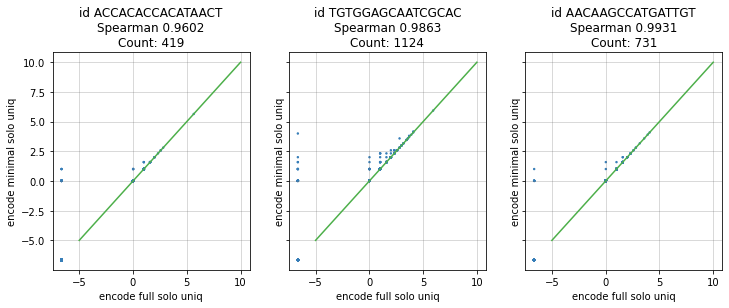

In [32]:
show_scatter_extremes(algorithm_dense, algorithm_correlations,'encode full solo uniq', 'encode minimal solo uniq')

# Scatter plot of cells with the highest expression sum

In [33]:
def plot_algorithm_most_expressed(table, correlations, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    f = pyplot.figure(figsize=(10, 10))
    if title is not None:
        f.suptitle(title.format(metric=metric))
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            max_cell = algorithm_dense[name_x].sum(axis=0).idxmax()
            scatter.setdefault(name_x, {})[name_y] = sc_scatter(table, correlations, name_x, name_y, max_cell, ax=ax)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Compare algorithms with cell with highest expression sum")
    #f.tight_layout()
    

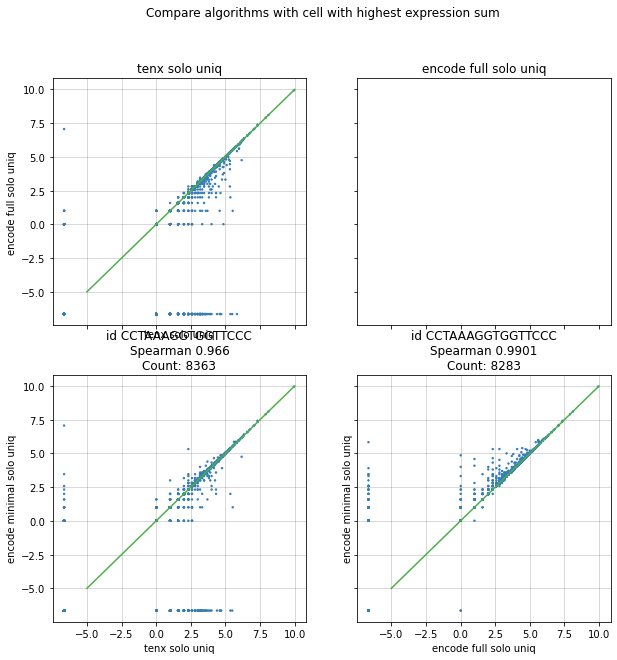

In [34]:
plot_algorithm_most_expressed(algorithm_dense, algorithm_correlations)

It seems weird that there's expression in encode minimal, but not in encode full, maybe I have the labels backward?

In [35]:
encode_minimal_uniq_sum = algorithm_dense['encode minimal solo uniq'].sum(axis=1)
encode_full_uniq_sum = algorithm_dense['encode full solo uniq'].sum(axis=1)

In [36]:
in_minimal_uniq_sum = encode_minimal_uniq_sum > 0
not_in_minimal_uniq_sum = encode_minimal_uniq_sum == 0
in_full_uniq_sum = encode_full_uniq_sum > 0
not_in_full_uniq_sum =(encode_full_uniq_sum == 0)

encode_minimal_uniq_sum[in_minimal_uniq_sum & not_in_full_uniq_sum]

ENSG00000225880.5        64.0
ENSG00000219073.7         4.0
ENSG00000142789.19        6.0
ENSG00000270103.3        22.0
ENSG00000214114.8       198.0
ENSG00000174021.10     6680.0
ENSG00000171488.14        1.0
ENSG00000270066.3       189.0
ENSG00000263590.2       387.0
ENSG00000272824.1         4.0
ENSG00000236334.2        15.0
ENSG00000236427.1        13.0
ENSG00000173110.7       196.0
ENSG00000235736.1         7.0
ENSG00000203601.3       241.0
ENSG00000243636.1         9.0
ENSG00000278467.1        28.0
ENSG00000143768.12        6.0
ENSG00000235152.1         1.0
ENSG00000153230.4         1.0
ENSG00000228198.3         1.0
ENSG00000243943.9      1377.0
ENSG00000273006.1         1.0
ENSG00000259439.2         1.0
ENSG00000187600.14        1.0
ENSG00000171150.8      2285.0
ENSG00000055813.5      2586.0
ENSG00000237651.6       558.0
ENSG00000281920.1        37.0
ENSG00000222041.11     1890.0
ENSG00000125551.18        5.0
ENSG00000211592.8     72336.0
ENSG00000211593.2       290.0
ENSG000002

# Quick glance at genes that are expressed in just in the minimal set

In [37]:
v29_gtf.set_index('gene_id').reindex(encode_minimal_uniq_sum[in_minimal_uniq_sum & not_in_full_uniq_sum].index)

,gene_name,gene_type,gene_base
ENSG00000225880.5,LINC00115,lincRNA,ENSG00000225880
ENSG00000219073.7,CELA3B,protein_coding,ENSG00000219073
ENSG00000142789.19,CELA3A,protein_coding,ENSG00000142789
ENSG00000270103.3,AL360012.1,lincRNA,ENSG00000270103
ENSG00000214114.8,MYCBP,protein_coding,ENSG00000214114
ENSG00000174021.10,GNG5,protein_coding,ENSG00000174021
ENSG00000171488.14,LRRC8C,protein_coding,ENSG00000171488
ENSG00000270066.3,AL356488.2,lincRNA,ENSG00000270066
ENSG00000263590.2,LINC02591,lincRNA,ENSG00000263590
ENSG00000272824.1,AC245100.7,lincRNA,ENSG00000272824


# Lets try the scanpy tutorial

tenx solo uniq first phase QC


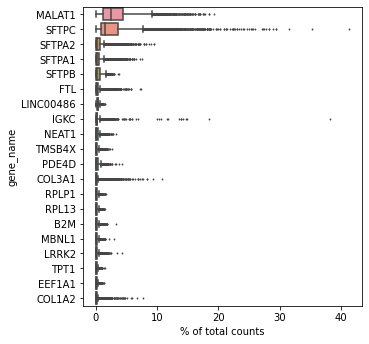

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

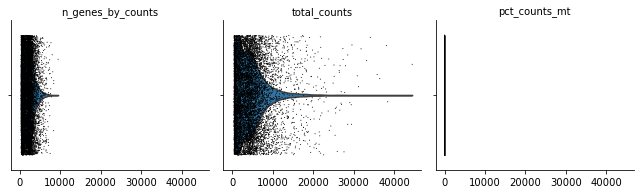

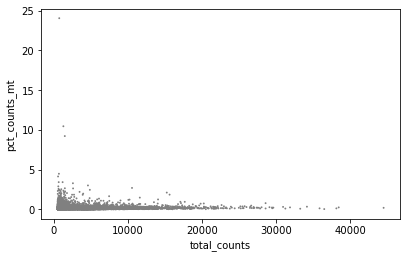

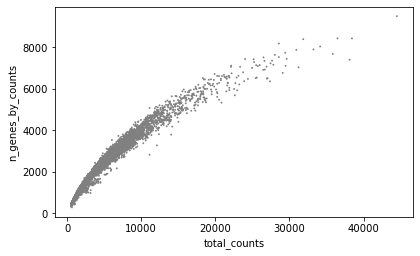

encode full solo uniq first phase QC


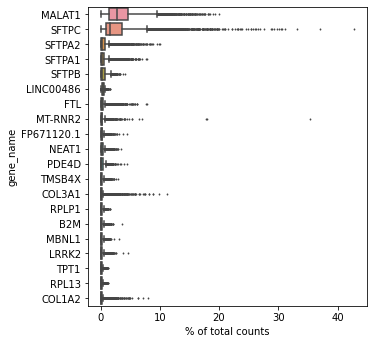

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

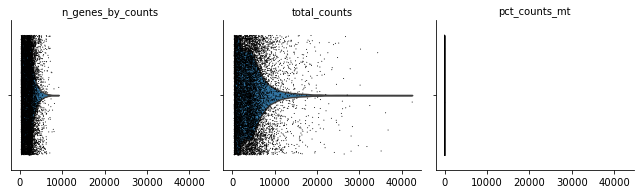

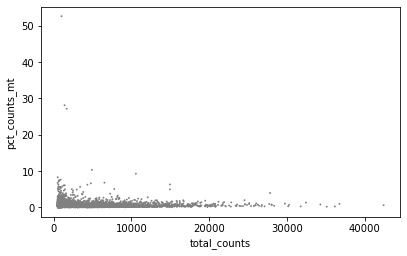

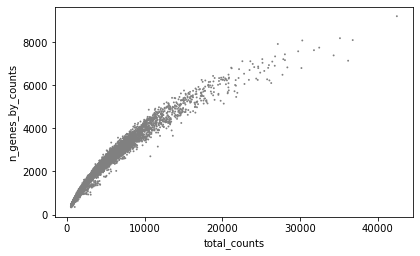

encode minimal solo uniq first phase QC


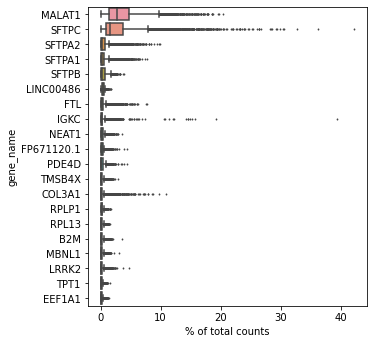

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

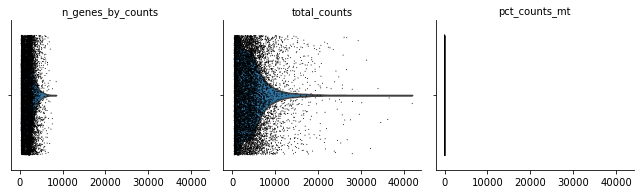

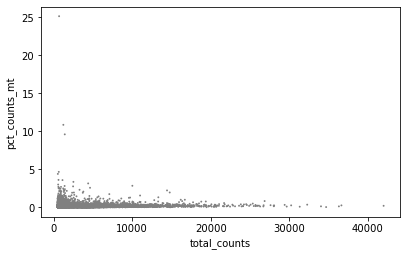

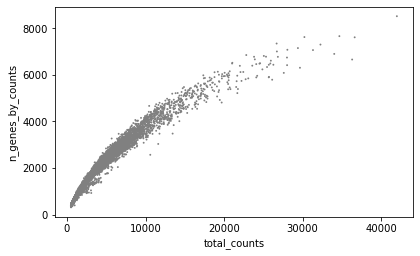

In [39]:
for algorithm in algorithm_filtered:
    print("{algorithm} first phase QC".format(algorithm=algorithm))
    if algorithm == "tenx solo uniq":
        algorithm_filtered[algorithm].var['gene_name'] = [v32m_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
    else:
        algorithm_filtered[algorithm].var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        
    scanpy.pl.highest_expr_genes(algorithm_filtered[algorithm], n_top=20, gene_symbols='gene_name')
    scanpy.pp.filter_cells(algorithm_filtered[algorithm], min_genes=200)
    scanpy.pp.filter_genes(algorithm_filtered[algorithm], min_cells=3)
    algorithm_filtered[algorithm].var['mt'] = algorithm_filtered[algorithm].var['gene_name'].str.startswith("MT-")
    scanpy.pp.calculate_qc_metrics(algorithm_filtered[algorithm], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    scanpy.pl.violin(
        algorithm_filtered[algorithm],
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, multi_panel=True)
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='pct_counts_mt')
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='n_genes_by_counts')        

In [40]:
algorithm_filtered[algorithm].obs

,counts,ngenes,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACAGCCAACCTAAT,922.0,616,616,616,922.0,7.0,0.759219
AAACAGCCAAGCTTAT,2549.0,1465,1465,1465,2549.0,6.0,0.235386
AAACATGCAAGGTAAC,4243.0,2151,2151,2151,4243.0,1.0,0.023568
AAACATGCAATATACC,2613.0,1476,1476,1475,2612.0,3.0,0.114855
AAACATGCACATAACT,5425.0,2762,2762,2762,5425.0,6.0,0.110599
...,...,...,...,...,...,...,...
TTTGTGTTCATCCTAT,892.0,637,637,637,892.0,2.0,0.224215
TTTGTGTTCGGTCATG,2244.0,1368,1368,1368,2244.0,11.0,0.490196
TTTGTTGGTAACAGGG,5827.0,3044,3044,3042,5825.0,6.0,0.103004
TTTGTTGGTGCATCGG,1382.0,773,773,773,1382.0,5.0,0.361795


tenx solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


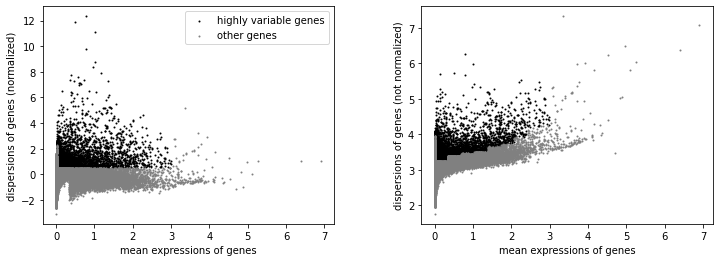

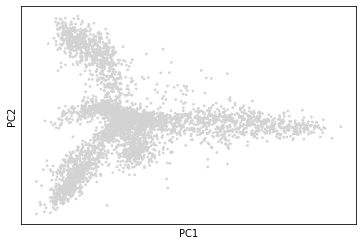

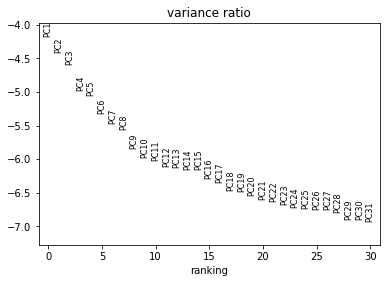

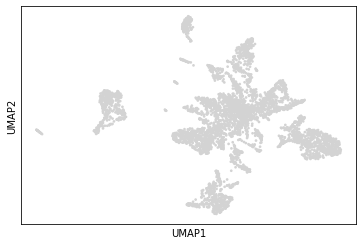

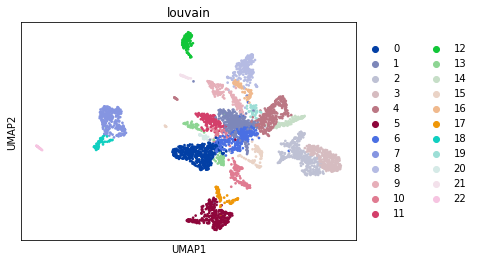

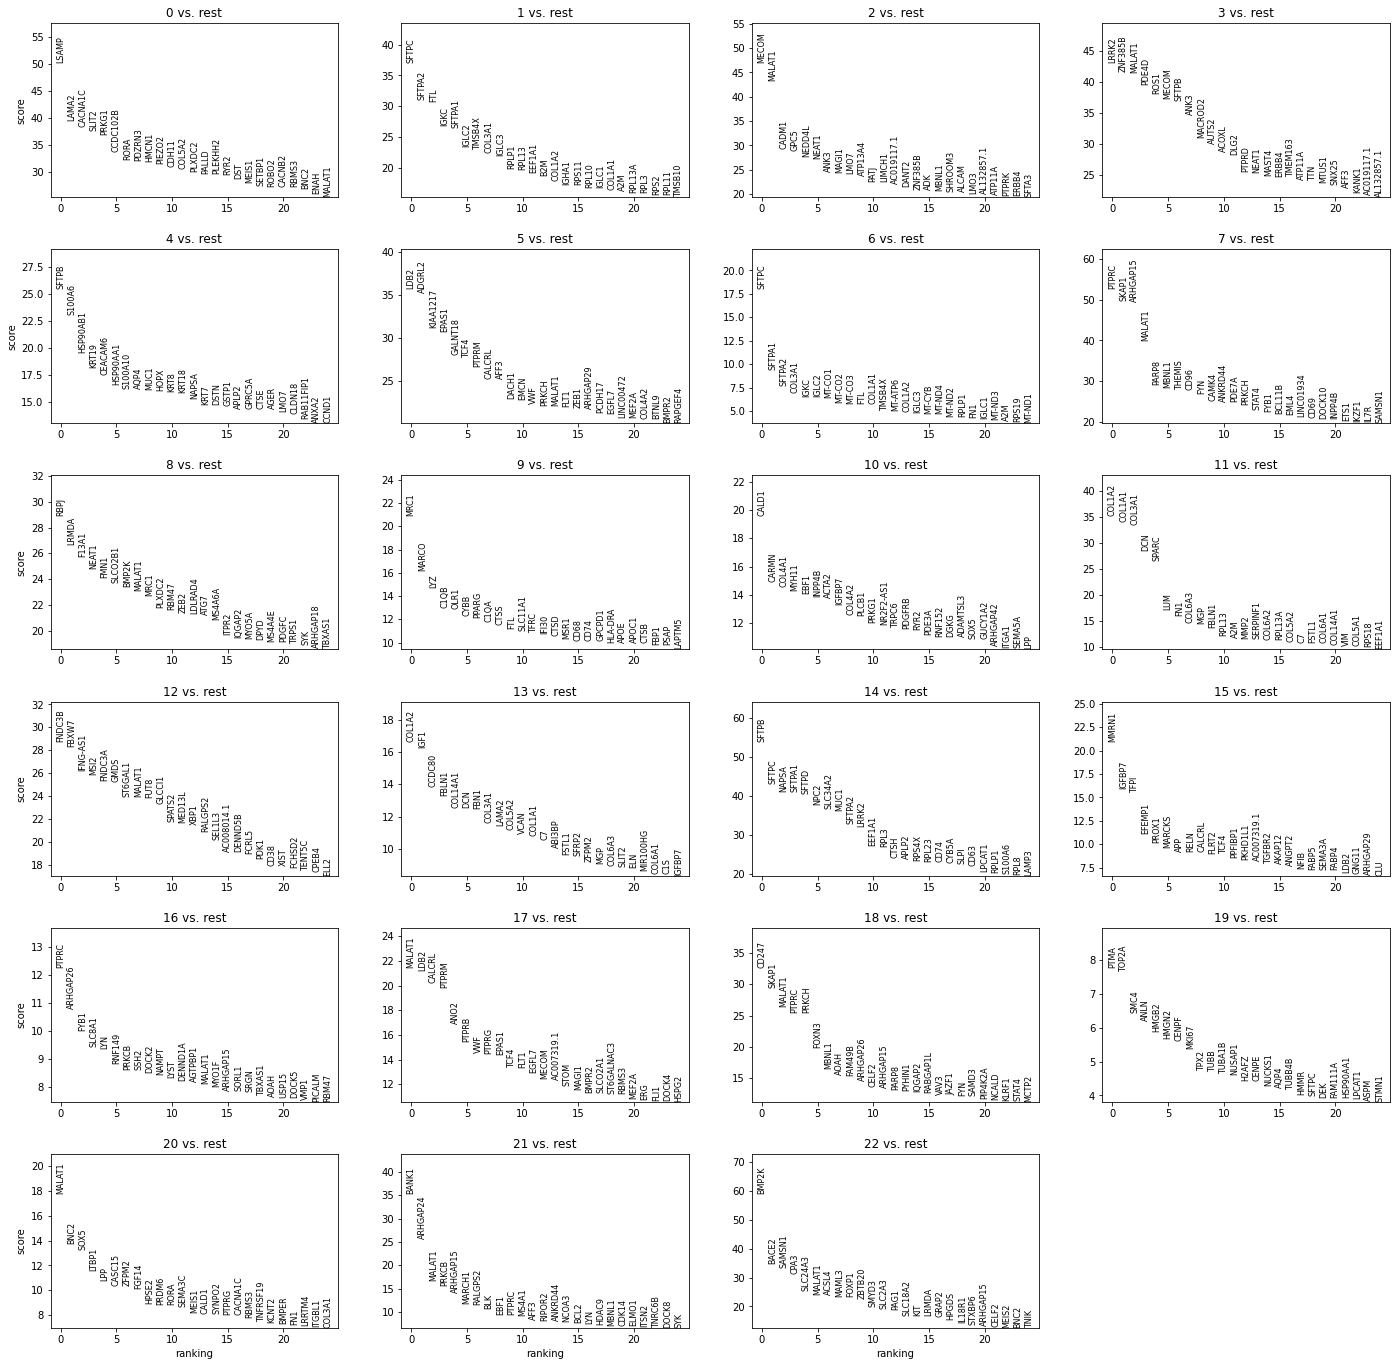

top gene names
         0       1       2        3         4         5       6         7  \
0    LSAMP   SFTPC   MECOM    LRRK2     SFTPB      LDB2   SFTPC     PTPRC   
1    LAMA2  SFTPA2  MALAT1  ZNF385B    S100A6    ADGRL2  SFTPA1     SKAP1   
2  CACNA1C     FTL   CADM1   MALAT1  HSP90AB1  KIAA1217  SFTPA2  ARHGAP15   
3    SLIT2    IGKC    GPC5    PDE4D     KRT19     EPAS1  COL3A1    MALAT1   
4    PRKG1  SFTPA1  NEDD4L     ROS1   CEACAM6   GALNT18    IGKC     PARP8   

       8      9  ...       13      14      15        16      17      18  \
0   RBPJ   MRC1  ...   COL1A2   SFTPB   MMRN1     PTPRC  MALAT1   CD247   
1  LRMDA  MARCO  ...     IGF1   SFTPC  IGFBP7  ARHGAP26    LDB2   SKAP1   
2  F13A1    LYZ  ...   CCDC80   NAPSA    TFPI      FYB1  CALCRL  MALAT1   
3  NEAT1   C1QB  ...    FBLN1  SFTPA1  EFEMP1    SLC8A1   PTPRM   PTPRC   
4   FMN1   OLR1  ...  COL14A1   SFTPD   PROX1       LYN    ANO2   PRKCH   

      19      20        21       22  
0   PTMA  MALAT1     BANK1    BMP

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


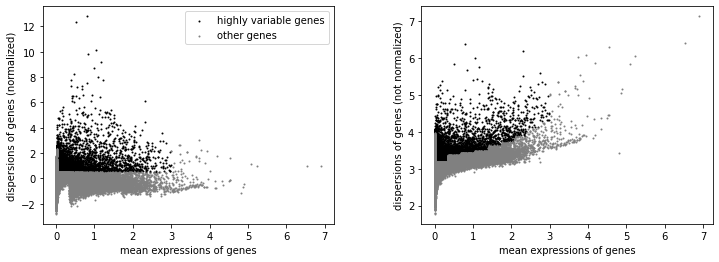

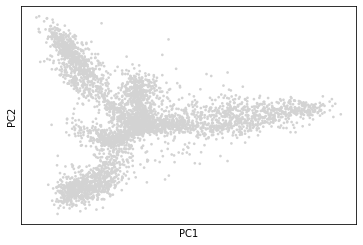

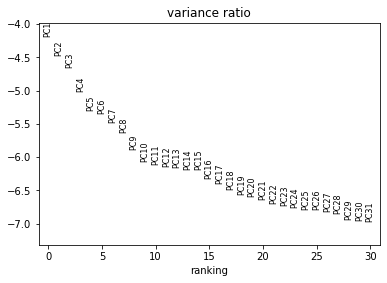

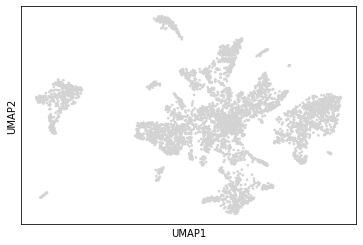

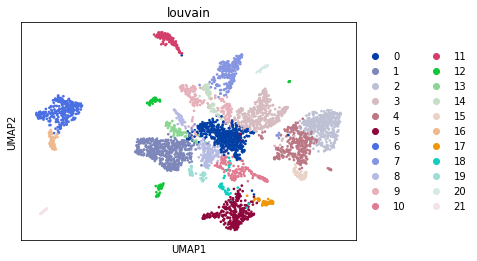

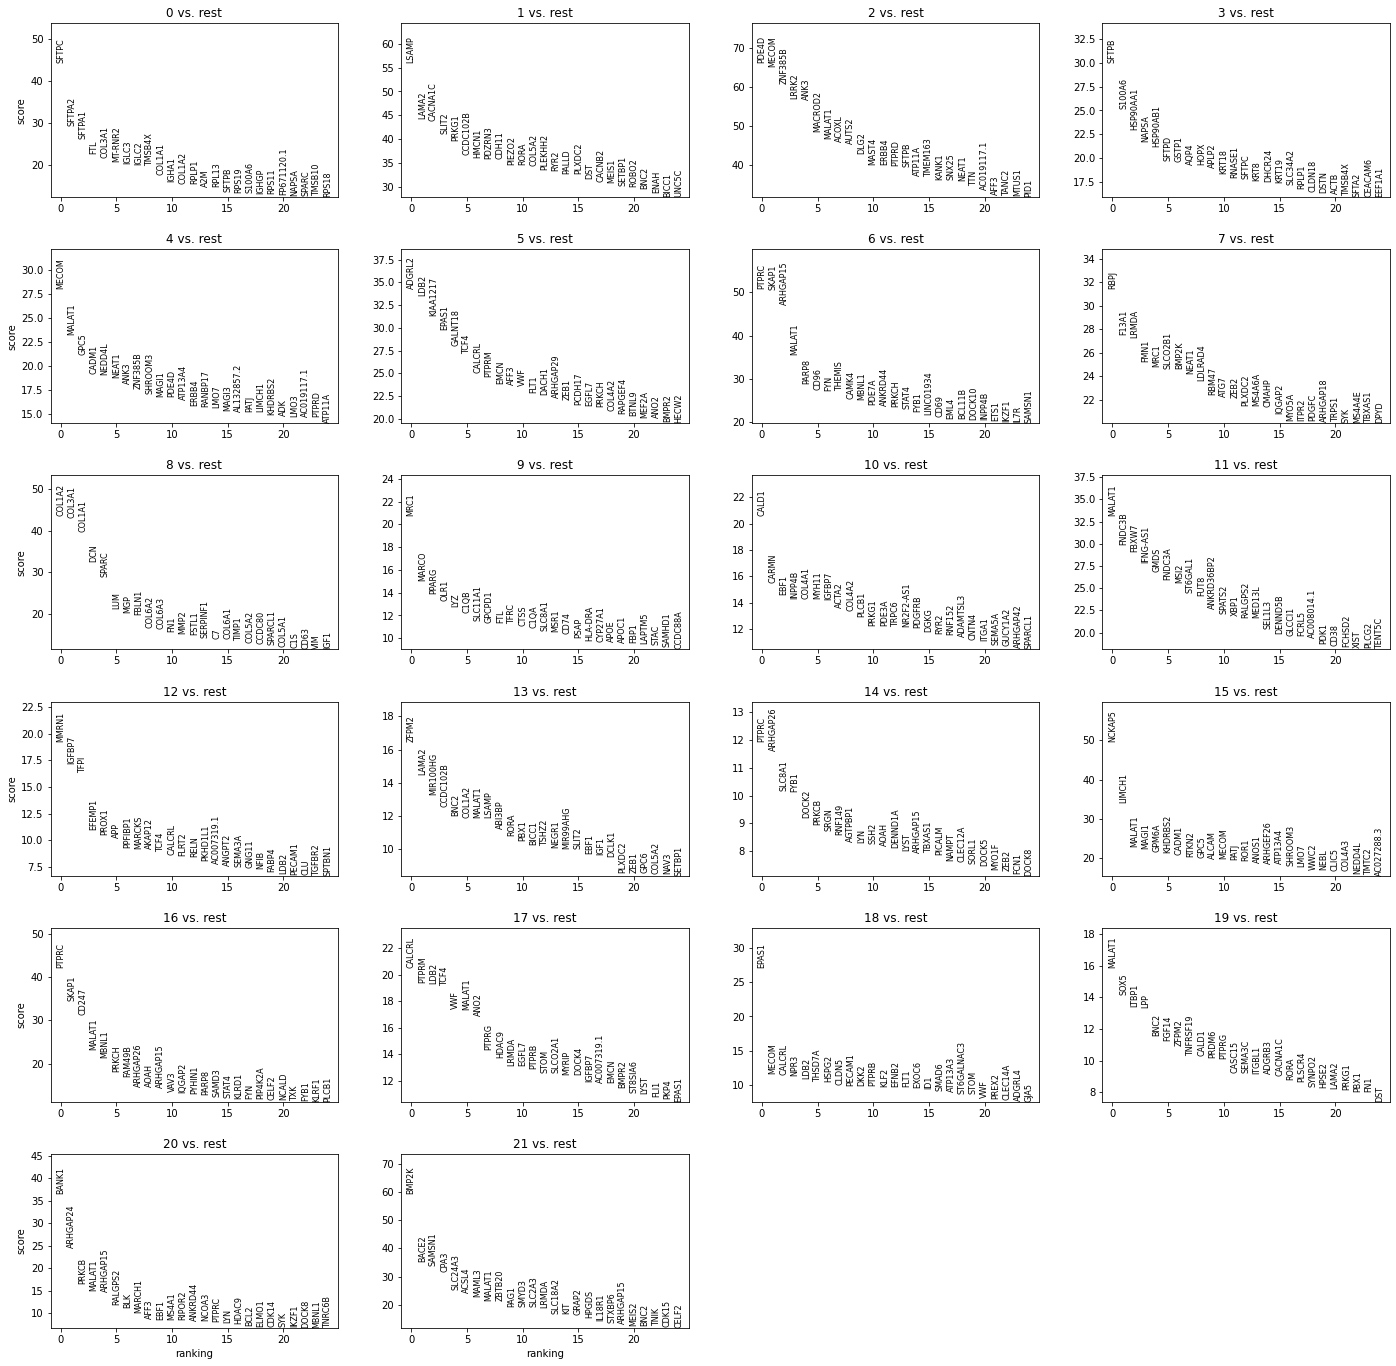

top gene names
        0        1        2         3       4         5         6      7  \
0   SFTPC    LSAMP    PDE4D     SFTPB   MECOM    ADGRL2     PTPRC   RBPJ   
1  SFTPA2    LAMA2    MECOM    S100A6  MALAT1      LDB2     SKAP1  F13A1   
2  SFTPA1  CACNA1C  ZNF385B  HSP90AA1    GPC5  KIAA1217  ARHGAP15  LRMDA   
3     FTL    SLIT2    LRRK2     NAPSA   CADM1     EPAS1    MALAT1   FMN1   
4  COL3A1    PRKG1     ANK3  HSP90AB1  NEDD4L   GALNT18     PARP8   MRC1   

        8      9  ...      12        13        14      15      16      17  \
0  COL1A2   MRC1  ...   MMRN1     ZFPM2     PTPRC  NCKAP5   PTPRC  CALCRL   
1  COL3A1  MARCO  ...  IGFBP7     LAMA2  ARHGAP26  LIMCH1   SKAP1   PTPRM   
2  COL1A1  PPARG  ...    TFPI  MIR100HG    SLC8A1  MALAT1   CD247    LDB2   
3     DCN   OLR1  ...  EFEMP1  CCDC102B      FYB1   MAGI1  MALAT1    TCF4   
4   SPARC    LYZ  ...   PROX1      BNC2     DOCK2   GPM6A   MBNL1     VWF   

       18      19        20       21  
0   EPAS1  MALAT1     BANK

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


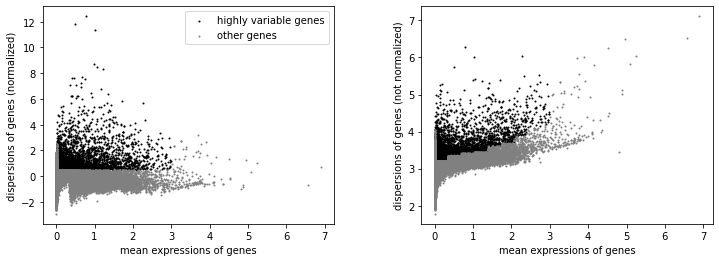

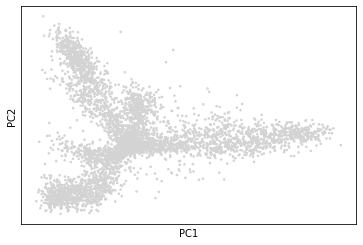

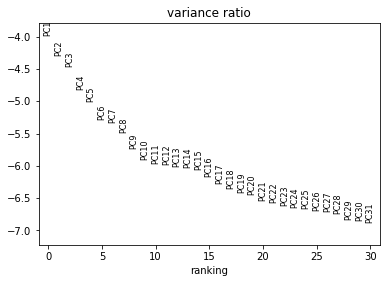

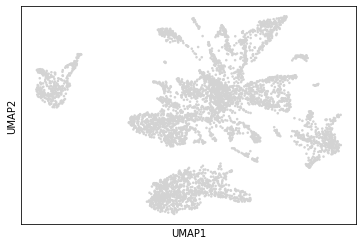

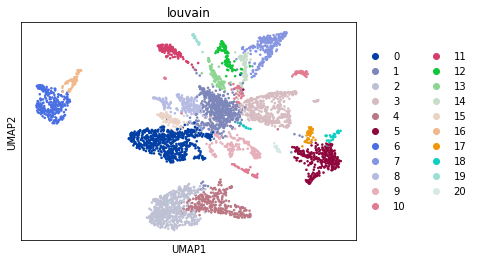

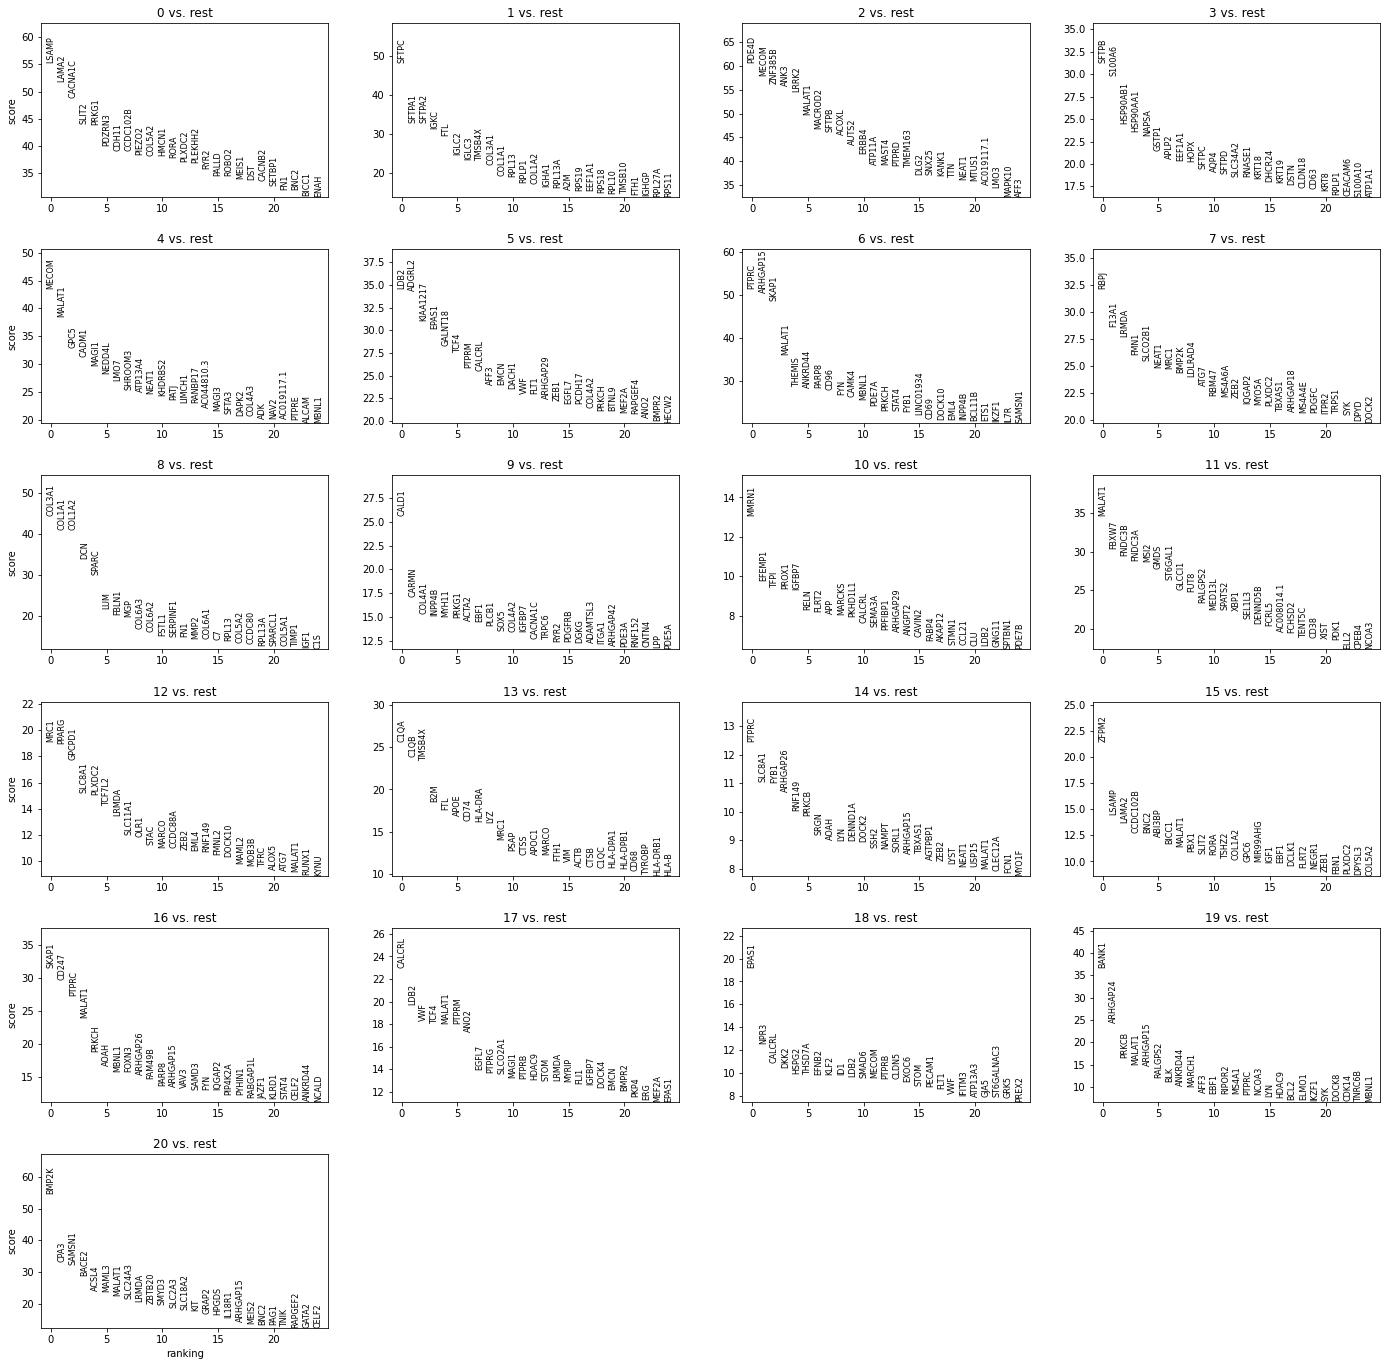

top gene names
         0       1        2         3       4         5         6        7  \
0    LSAMP   SFTPC    PDE4D     SFTPB   MECOM      LDB2     PTPRC     RBPJ   
1    LAMA2  SFTPA1    MECOM    S100A6  MALAT1    ADGRL2  ARHGAP15    F13A1   
2  CACNA1C  SFTPA2  ZNF385B  HSP90AB1    GPC5  KIAA1217     SKAP1    LRMDA   
3    SLIT2    IGKC     ANK3  HSP90AA1   CADM1     EPAS1    MALAT1     FMN1   
4    PRKG1     FTL    LRRK2     NAPSA   MAGI1   GALNT18    THEMIS  SLCO2B1   

        8       9  ...      11      12      13        14        15      16  \
0  COL3A1   CALD1  ...  MALAT1    MRC1    C1QA     PTPRC     ZFPM2   SKAP1   
1  COL1A1   CARMN  ...   FBXW7   PPARG    C1QB    SLC8A1     LSAMP   CD247   
2  COL1A2  COL4A1  ...  FNDC3B  GPCPD1  TMSB4X      FYB1     LAMA2   PTPRC   
3     DCN  INPP4B  ...  FNDC3A  SLC8A1     B2M  ARHGAP26  CCDC102B  MALAT1   
4   SPARC   MYH11  ...    MSI2  PLXDC2     FTL    RNF149      BNC2   PRKCH   

       17      18        19      20  
0  CALCRL

In [41]:
algorithm_scanpy_filtered = {}
algorithm_top_gene_ids = {}
algorithm_top_gene_names = {}
for algorithm in algorithm_filtered:
    #print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
    print("{algorithm} clustering".format(algorithm=algorithm))
    algorithm_scanpy_filtered[algorithm] = algorithm_filtered[algorithm][algorithm_filtered[algorithm].obs.n_genes_by_counts < 2000, :]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][algorithm_scanpy_filtered[algorithm].obs.pct_counts_mt < 2.5, :]
    
    scanpy.pp.normalize_total(algorithm_scanpy_filtered[algorithm], target_sum=30000)
    scanpy.pp.log1p(algorithm_scanpy_filtered[algorithm])
    scanpy.pp.highly_variable_genes(algorithm_scanpy_filtered[algorithm], min_mean=0.0125, max_mean=3, min_disp=0.5)
    scanpy.pl.highly_variable_genes(algorithm_scanpy_filtered[algorithm])
    algorithm_scanpy_filtered[algorithm].raw = algorithm_scanpy_filtered[algorithm]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][:, algorithm_scanpy_filtered[algorithm].var.highly_variable]
   
    scanpy.pp.regress_out( algorithm_scanpy_filtered[algorithm], ['total_counts', 'pct_counts_mt'])
    scanpy.pp.scale( algorithm_scanpy_filtered[algorithm], max_value=10)
    scanpy.tl.pca(algorithm_scanpy_filtered[algorithm], svd_solver='arpack')
    scanpy.pl.pca(algorithm_scanpy_filtered[algorithm])

    scanpy.pl.pca_variance_ratio(algorithm_scanpy_filtered[algorithm], log=True)
    
    scanpy.pp.neighbors(algorithm_scanpy_filtered[algorithm], n_neighbors=10, n_pcs=40)
    scanpy.tl.umap(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm])
    
    scanpy.tl.louvain(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm], color=['louvain'])
    
    scanpy.tl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], 'louvain', method='t-test')
    scanpy.pl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], n_genes=25, sharey=False, gene_symbols='gene_name')
    
    algorithm_top_gene_ids[algorithm] = pandas.DataFrame(algorithm_scanpy_filtered[algorithm].uns['rank_genes_groups']['names'])    
    if algorithm == "tenx solo uniq":
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v32m_gene_id_to_name.get(x, x))
    else:
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v29_gene_id_to_name.get(x, x))
    print('top gene names')
    print(algorithm_top_gene_names[algorithm].head(5))

# Cell barcodes left in common after scanpy filtering

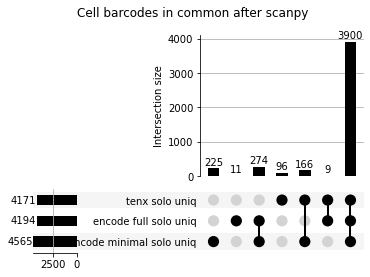

In [42]:
tutoral_barcode_set = upsetplot.from_contents({
    k: algorithm_scanpy_filtered[k].obs_names for k in algorithm_scanpy_filtered
})
f = pyplot.figure()
f.suptitle("Cell barcodes in common after scanpy")
_ = upsetplot.plot(tutoral_barcode_set, show_counts=True, fig=f)


# Gene IDs in common after scanpy filtering

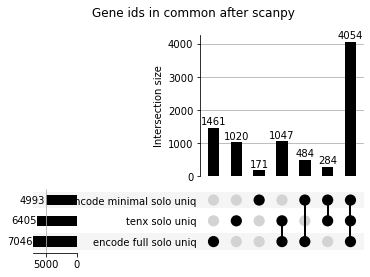

In [43]:
common_filtered_gene_base_contents = {}
for algorithm in algorithm_scanpy_filtered:
    #if algorithm == 'tenx solo uniq':
    #    common_filtered_gene_base_contents[algorithm] = {gene_id for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    #else:
    #common_filtered_gene_base_contents[algorithm] = {gene_id.split('.')[0] for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    common_filtered_gene_base_contents[algorithm] = set(algorithm_scanpy_filtered[algorithm].var_names)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_filtered_gene_base_set = upsetplot.from_contents(common_filtered_gene_base_contents)

f = pyplot.figure()
f.suptitle("Gene ids in common after scanpy")
_ = upsetplot.plot(common_filtered_gene_base_set, show_counts=True, fig=f)

In [44]:
common_filtered_gene_base_set.loc[True, False, True]['id']

<ipython-input-44-da2e8eb8c94a>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  common_filtered_gene_base_set.loc[True, False, True]['id']


tenx solo uniq  encode full solo uniq  encode minimal solo uniq
True            False                  True                        ENSG00000179348.11
                                       True                         ENSG00000179388.8
                                       True                        ENSG00000124772.11
                                       True                         ENSG00000248150.1
                                       True                        ENSG00000182612.10
                                       True                         ENSG00000170819.4
                                       True                         ENSG00000272674.3
                                       True                        ENSG00000138100.13
                                       True                         ENSG00000273270.1
                                       True                         ENSG00000225564.6
                                       True                         ENSG0000

In [45]:
v29_gtf.set_index('gene_id').reindex(common_filtered_gene_base_set.loc[True, False, True]['id'])

<ipython-input-45-6d8f821337f9>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  v29_gtf.set_index('gene_id').reindex(common_filtered_gene_base_set.loc[True, False, True]['id'])


,gene_name,gene_type,gene_base
id,,,
ENSG00000179348.11,GATA2,protein_coding,ENSG00000179348
ENSG00000179388.8,EGR3,protein_coding,ENSG00000179388
ENSG00000124772.11,CPNE5,protein_coding,ENSG00000124772
ENSG00000248150.1,LINC02150,lincRNA,ENSG00000248150
ENSG00000182612.10,TSPAN10,protein_coding,ENSG00000182612
ENSG00000170819.4,BFSP2,protein_coding,ENSG00000170819
ENSG00000272674.3,PCDHB16,protein_coding,ENSG00000272674
ENSG00000138100.13,TRIM54,protein_coding,ENSG00000138100
ENSG00000273270.1,AC090114.2,lincRNA,ENSG00000273270


In [46]:
def build_confusion_matrix(left, right, N=20):
    confusion = {}
    for cluster in left:
        for gene in left[cluster].head(N):
            confusion.setdefault(gene, {})['left'] = int(cluster)

    for cluster in right:
        for gene in right[cluster].head(N):
            confusion.setdefault(gene, {})['right'] = int(cluster)

    last_left = int(left.columns[-1]) + 1
    last_right = int(right.columns[-1]) + 1

    confusion_matrix = numpy.zeros((last_left+1, last_right+1))

    for gene in confusion:
        x = confusion[gene].get('left', last_left)
        y = confusion[gene].get('right', last_right)
        confusion_matrix[x,y] += 1
    return confusion_matrix

# Confusion matrices between top N genes in each cluster

In [47]:
def plot_algorithm_confusion(table, programs=None, N=20):
    if programs is None:
        programs = list(table.keys())
    confusion = {}
    f = pyplot.figure(figsize=(16, 16))
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            cm = build_confusion_matrix(table[name_x], table[name_y], N)
            seaborn.heatmap(cm, annot=False, ax=ax)
            
            if x == 0:
                ax.set_ylabel(name_y)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Gene name confusion matrix of top {} genes".format(N))
    #f.tight_layout()


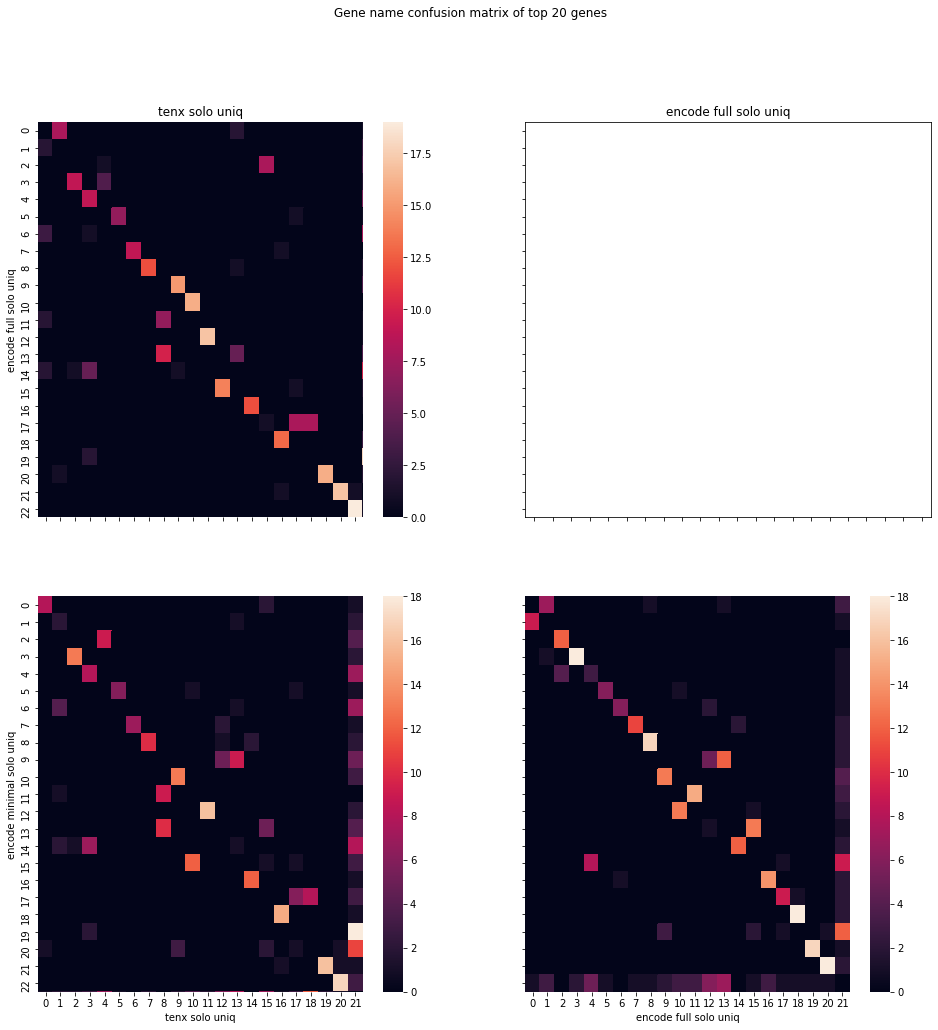

In [48]:
plot_algorithm_confusion(algorithm_top_gene_names, N=20)

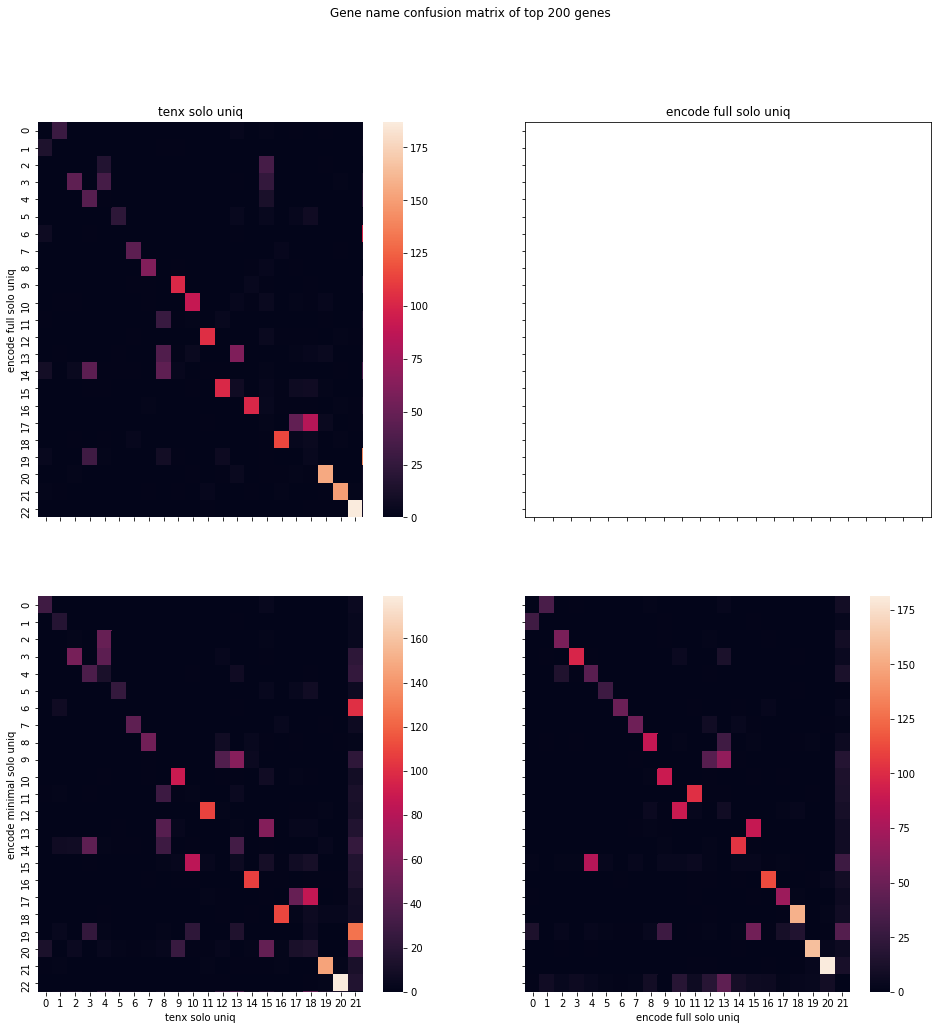

In [49]:
plot_algorithm_confusion(algorithm_top_gene_names, N=200)

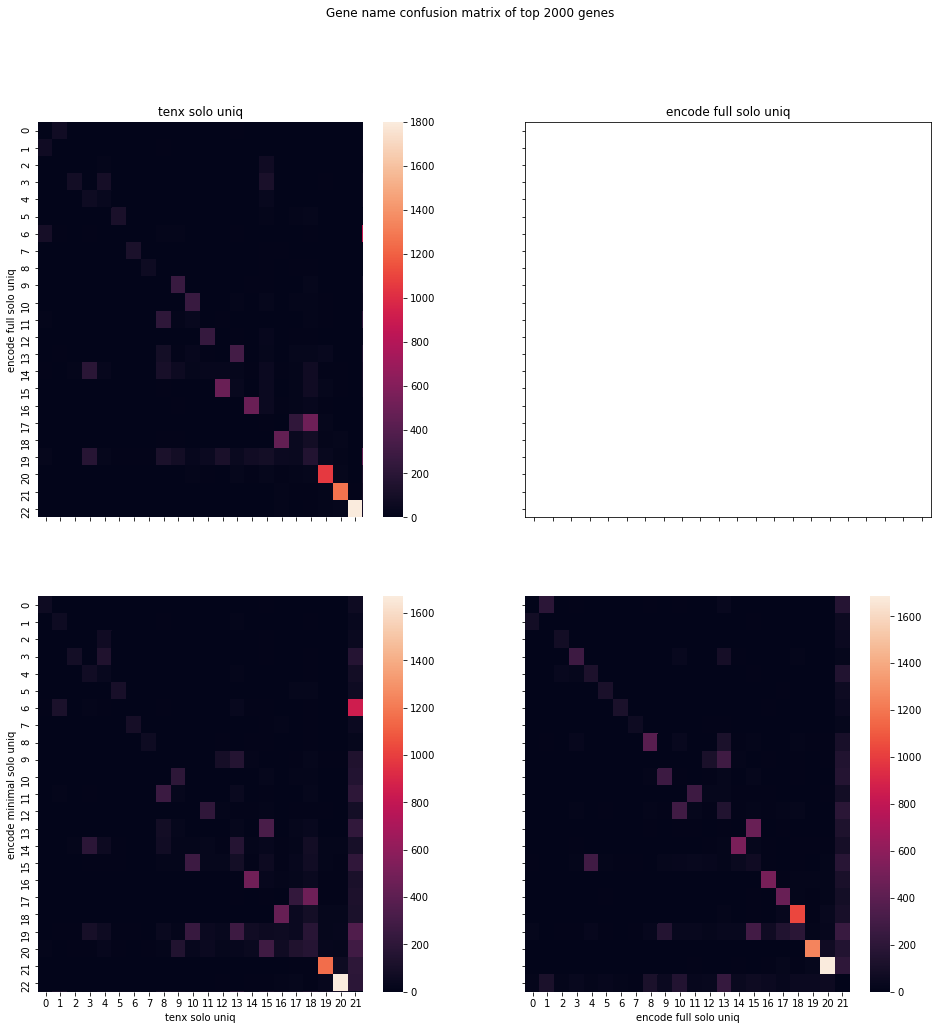

In [50]:
plot_algorithm_confusion(algorithm_top_gene_names, N=2000)